In [1]:
#librairy 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [23]:
df = sns.load_dataset('titanic')
df.head(5) 

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [24]:
df.drop(['deck','class','alive','embark_town','who'],axis=1,inplace=True) 




In [25]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [26]:
df['male'] = pd.get_dummies(df['sex'],drop_first=True)
df[['class_2','class_3']] = pd.get_dummies(df['pclass'],drop_first=True)
df[['embarked_Q','embarked_S']] = pd.get_dummies(df['embarked'],drop_first=True)

#Drop emabrked
df.drop(['embarked','sex','pclass'],inplace=True,axis=1)

#Convert bool to int (binary)
df.alone = df.alone.astype(int)
df.adult_male = df.adult_male.astype(int)

y = df.survived 

X = df.drop('survived',axis=1)
X = sm.add_constant(X)

est = sm.OLS(y,X).fit(cov_type='HC2')

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     87.54
Date:                Thu, 11 Feb 2021   Prob (F-statistic):          1.45e-123
Time:                        08:35:08   Log-Likelihood:                -293.74
No. Observations:                 712   AIC:                             611.5
Df Residuals:                     700   BIC:                             666.3
Df Model:                          11                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1999      0.067     17.820      0.000       1.068       1.332
age           -0.0033      0.001     -2.902      0.004      -0.006      -0.001
sibsp         -0.1216      0.020     -5.972      0.000      -0.161      -0.082
parch         -0.0568      0.022     -2.602      0.009      -0.100      -0.014
fare           0.0004      0.000      1.058      0.290      -0.000       0.001
adult_male    -0.5450      0.073     -7.510      0.000      -0.687      -0.403
alone         -0.1030      0.043     -2.387      0.017      -0.188      -0.018
male          -0.0090      0.068     -0.131      0.896      -0.143       0.125
class_2       -0.1631      0.047     -3.478      0.001      -0.255      -0.071
class_3       -0.3186      0.052     -6.101      0.000      -0.421      -0.216
embarked_Q    -0.1201      0.081     -1.486      0.137      -0.278       0.038
embarked_S    -0.0494      0.042     -1.187      0.235      -0.131       0.032
==============================================================================
Omnibus:                       34.297   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.481
Skew:                           0.524   Prob(JB):                     4.40e-09
Kurtosis:                       3.446   Cond. No.                         498.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

log_model = LogisticRegression(random_state=0)

log_model.fit(X_scaled,y)

log_model.coef_

array([[ 0.        , -0.34259526, -0.55824667, -0.24566481,  0.13263286,
        -1.40856975, -0.17858768, -0.09356377, -0.47648681, -1.0819531 ,
        -0.17014653, -0.13983957]])

In [30]:
log_mod = sm.Logit(y,X).fit()
log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.417785
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           11
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.3809
Time:                        08:40:14   Log-Likelihood:                -297.46
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.004e-71
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2603      0.559      7.627      0.000       3.165       5.355
age           -0.0241      0.009     -2.686      0.007      -0.042      -0.007
sibsp         -0.6301      0.157     -4.023      0.000      -0.937      -0.323
parch         -0.2980      0.150     -1.992      0.046      -0.591      -0.005
fare           0.0023      0.003      0.851      0.395      -0.003       0.008
adult_male    -3.0613      0.552     -5.550      0.000      -4.142      -1.980
alone         -0.3706      0.320     -1.158      0.247      -0.998       0.257
male          -0.0406      0.507     -0.080      0.936      -1.035       0.954
class_2       -1.1850      0.344     -3.448      0.001      -1.859      -0.511
class_3       -2.2523      0.360     -6.265      0.000      -2.957      -1.548
embarked_Q    -0.8847      0.604     -1.466      0.143      -2.068       0.298
embarked_S    -0.3254      0.287     -1.134      0.257      -0.888       0.237
==============================================================================
"""

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lin_model = LinearRegression().fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)

log_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
log_y_pred = log_model.predict(X_test)

f = lambda x: 1 if x > 0.5 else 0
f_vec = np.vectorize(f)

print(classification_report(y_test, f_vec(lin_y_pred)))
print(classification_report(y_test, log_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       125
           1       0.76      0.70      0.73        89

    accuracy                           0.78       214
   macro avg       0.78      0.77      0.77       214
weighted avg       0.78      0.78      0.78       214

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       125
           1       0.75      0.69      0.72        89

    accuracy                           0.78       214
   macro avg       0.77      0.76      0.77       214
weighted avg       0.77      0.78      0.77       214



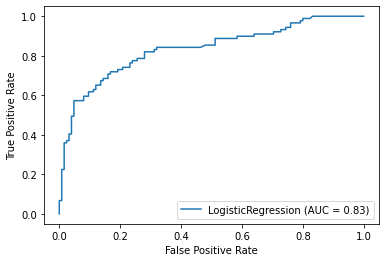

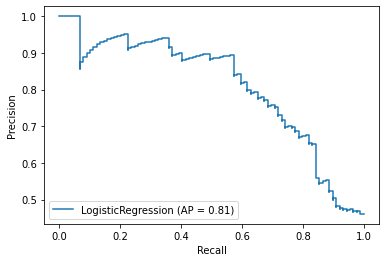

In [34]:
plot_roc_curve(log_model,X_test,y_test)

plot_precision_recall_curve(log_model,X_test,y_test)

In [109]:
#The f1 score is similar to the linear regression, however, the r2 score from the logistic regression is better. 

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [35]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [50]:
size = 10_000

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=size, random_state=42)

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test) 

log_model = LogisticRegression(solver='lbfgs',max_iter=1000)


In [51]:
log_model.fit(scaled_X_train,y_train)

LogisticRegression(max_iter=1000)

In [53]:
y_pred = log_model.predict(scaled_X_test)

In [54]:
print(f'Accuracy of Logistic Regression on test set: {accuracy_score(y_test,y_pred)}')
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy of Logistic Regression on test set: 0.9161
[[ 940    0    8    1    1   10   12    4    6    1]
 [   0 1122    5    5    1    4    1    3    8    3]
 [   7   13  866   14    6    9   16   11   21    4]
 [   3    8   23  921    2   30    4   15   14   14]
 [   4    1    6    5  836    4   10    6    6   28]
 [  10    6    6   37    8  812   15    2   31   10]
 [   6    6   12    1    8   14  909    2    3    0]
 [   1    2   21    3   12    4    1  990    1   20]
 [   7   21   13   35    4   34   12    6  822   15]
 [   5    7    4   10   25    4    0   29    9  943]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.95      0.97      0.96      1152
           2       0.90      0.90      0.90       967
           3       0.89      0.89      0.89      1034
           4       0.93      0.92      0.92       906
           5       0.88      0.87      0.87       937
           6       0.93      0.95     

In [108]:
#the diagonal is  strong, and our classification report is returning a 0.93% accuracy. 

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [58]:
df = pd.read_csv('data/fish.csv')

y = df.FISH_COUNT
X = sm.add_constant(df.drop('FISH_COUNT', axis=1))

<AxesSubplot:xlabel='FISH_COUNT', ylabel='Count'>

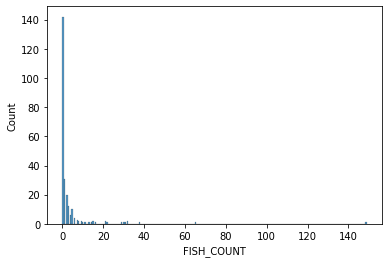

In [61]:
#plot the distribution to find the right model 
sns.histplot(y)
#it looks like a poisson distrubtion with a huge amount of 0 values. Zeroinflated model could be a good option

In [63]:
model = sm.ZeroInflatedPoisson(y,X).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
C:\Users\Yuri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Fri, 12 Feb 2021   Pseudo R-squ.:                  0.3471
Time:                         08:50:07   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

In [66]:
#let's try the two stage Modelling

#Stage 1 

est_1 = sm.Logit((y > 0), X).fit()

#est_1.summary()

#Stage 2 

X = pd.DataFrame(sm.add_constant(X))
X['stage1'] = est_1.predict(X)

est_2 = sm.Poisson(y,X).fit()
#sm.graphics.plot_fit(est2,5,vlines=False)
est_2.summary()

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6
Optimization terminated successfully.
         Current function value: 3.145454
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      244
Method:                           MLE   Df Model:                            5
Date:                Fri, 12 Feb 2021   Pseudo R-squ.:                  0.5228
Time:                        08:52:12   Log-Likelihood:                -786.36
converged:                       True   LL-Null:                       -1647.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1977      0.266    -12.018      0.000      -3.719      -2.676
LIVE_BAIT      1.9649      0.250      7.858      0.000       1.475       2.455
CAMPER         1.0589      0.119      8.895      0.000       0.826       1.292
PERSONS        1.4232      0.112     12.689      0.000       1.203       1.643
CHILDREN      -2.4239      0.231    -10.512      0.000      -2.876      -1.972
stage1        -2.1432      0.642     -3.339      0.001      -3.401      -0.885
==============================================================================
"""

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [80]:
#5.1 StreamingTV churn
from lifelines import KaplanMeierFitter

df = pd.read_csv('data/telco_churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<AxesSubplot:xlabel='timeline'>

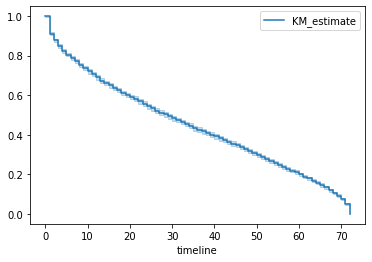

In [81]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
kmf = KaplanMeierFitter() 
tenure = df['tenure']     
turnover = df['Churn']

kmf = KaplanMeierFitter()
kmf.fit(tenure)
kmf.plot_survival_function()

<AxesSubplot:xlabel='timeline'>

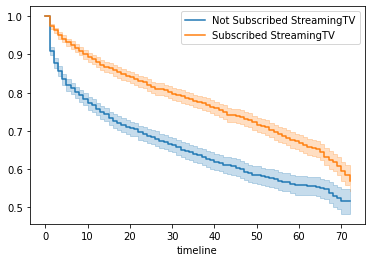

In [82]:

kmf1 = KaplanMeierFitter() 
streaming = df['StreamingTV']
i1 = (streaming == 'No')      
i2 = (streaming == 'Yes')     
kmf1.fit(tenure[i1], turnover[i1], label = 'Not Subscribed StreamingTV')
a1 = kmf1.plot()
kmf1.fit(tenure[i2], turnover[i2], label = 'Subscribed StreamingTV')
kmf1.plot(ax = a1)

In [103]:
df_1 = pd.read_csv('data/telco_churn.csv')

df_1.TotalCharges = pd.to_numeric(df_1.TotalCharges, errors='coerce')
df_1.TotalCharges[df_1.TotalCharges.isnull()] = df_1.MonthlyCharges


df_1 = df_1.drop(['customerID', 'gender'], axis=1)

# Turning 'Yes' into 1 and the rest ('No' and 'No _ service') into 0
cat = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for c in cat:
    df_1[c] = df_1[c].apply(lambda x: 1 if x == 'Yes' else 0)

# categories for OHE
cat_var = ['Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


ohe = pd.get_dummies(data=df_1, columns=cat_var, drop_first=True)

ohe.head()

,SeniorCitizen,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,...,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,0,0,1,0,0,0,0,29.85,...,0,0,0,0,0,1,0,1,0,0
1,0,34,0,1,0,1,0,0,0,56.95,...,1,0,0,1,0,0,0,0,1,0
2,0,2,0,1,1,0,0,0,0,53.85,...,1,0,0,0,0,1,0,0,1,1
3,0,45,0,1,0,1,1,0,0,42.30,...,0,0,0,1,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,70.70,...,1,1,0,0,0,1,0,1,0,1


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12660.05
         time fit was run = 2021-02-12 14:26:59 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.03       1.03       0.06            -0.08             0.14                 0.93                 1.16
MultipleLines                           0.09       1.10       0.13            -0.15             0.34                 0.86                 1.40
OnlineSecurity                         -0.21       0.81       0.13            -0.47             0.05                 0.63                 1.05
OnlineBackup                           -0.05       0.95       0.13            -0.30             0.20                 0.74                 1.22
DeviceProtection                        0.09       1.10       0.13            -0.16             0.34                 0.86                 1.40
TechSupport                            -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
StreamingTV                             0.29       1.34       0.24            -0.17             0.75                 0.84                 2.12
StreamingMovies                         0.30       1.35       0.24            -0.16             0.76                 0.85                 2.13
MonthlyCharges                          0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Partner_Yes                            -0.18       0.84       0.06            -0.29            -0.07                 0.75                 0.93
Dependents_Yes                         -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
PhoneService_Yes                        0.85       2.35       0.47            -0.08             1.78                 0.93                 5.93
InternetService_Fiber optic             1.04       2.83       0.58            -0.09             2.17                 0.91                 8.79
InternetService_No                     -2.36       0.09       0.59            -3.53            -1.20                 0.03                 0.30
Contract_One year                      -1.27       0.28       0.10            -1.47            -1.07                 0.23                 0.34
Contract_Two year                      -3.70       0.02       0.20            -4.10            -3.31                 0.02                 0.04
PaperlessBilling_Yes                    0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
PaymentMethod_Electronic check          0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
PaymentMethod_Mailed check              0.51       1.66       0.09             0.34             0.68                 1.40                 1.97

                                           z      p   -log2(p)
covariate                                                     
SeniorCitizen                           0.60   0.55       0.87
MultipleLines                           0.74   0.46       1.11
OnlineSecurity                         -1.56   0.12       3.07
OnlineBackup              

None


<AxesSubplot:xlabel='log(HR) (95% CI)'>

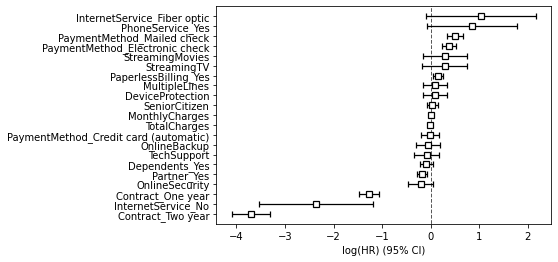

In [99]:
#5.2 Implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

# CoxPHFitter regression:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(ohe, 'tenure', event_col='Churn_Yes')
print(cph.print_summary())
cph.plot()

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8145.17
         time fit was run = 2021-02-12 14:35:25 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Contract_One year                       0.50       1.65       0.06             0.38             0.62                 1.46                 1.86
        Contract_Two year                       1.14       3.13       0.11             0.92             1.36                 2.50                 3.90
        Dependents_Yes                          0.10       1.10       0.05             0.01             0.19                 1.01                 1.21
        DeviceProtection                       -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.17
        InternetService_Fiber optic            -0.60       0.55       0.38            -1.35             0.14                 0.26                 1.15
        InternetService_No                      1.06       2.87       0.39             0.30             1.82                 1.34                 6.15
        MonthlyCharges                         -0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
        MultipleLines                          -0.00       1.00       0.08            -0.17             0.16                 0.85                 1.17
        OnlineBackup                            0.04       1.04       0.08            -0.12             0.20                 0.88                 1.23
        OnlineSecurity                          0.19       1.21       0.09             0.02             0.36                 1.02                 1.43
        PaperlessBilling_Yes                   -0.11       0.90       0.04            -0.18            -0.03                 0.84                 0.97
        Partner_Yes                             0.11       1.11       0.04             0.04             0.18                 1.04                 1.19
        PaymentMethod_Credit card (automatic)   0.04       1.04       0.06            -0.08             0.16                 0.93                 1.17
        PaymentMethod_Electronic check         -0.24       0.79       0.05            -0.33            -0.15                 0.72                 0.86
        PaymentMethod_Mailed check             -0.25       0.78       0.06            -0.36            -0.14                 0.70                 0.87
        PhoneService_Yes                       -0.20       0.82       0.31            -0.81             0.41                 0.45                 1.50
        SeniorCitizen                          -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.05
        StreamingMovies                        -0.13       0.88       0.15            -0.44             0.17                 0.65                 1.19
        StreamingTV                            -0.15       0.86       0.16            -0.45             0.16                 0.64                 1.17
        TechSupport                             0.13       1.14       0.09            -0.04             0.30                 0.96                 1.35
        TotalCharges                            0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        Intercept                               3.13      22.88       0.39             2.37             3.89                10.75                48.69
rho_    Intercept                      

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

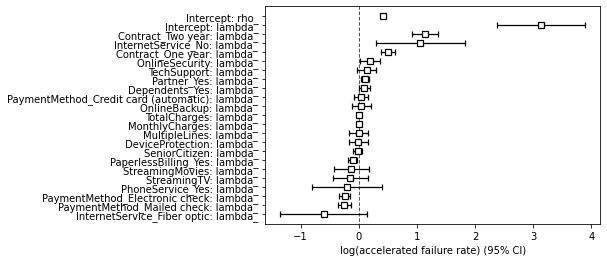

In [106]:
# WeibullAFTFitter Regression
from lifelines import WeibullAFTFitter

#based on the error suggesion, ill try to add a small positive value to my zero elements. 
ohe.tenure = ohe.tenure +0.25


wft = WeibullAFTFitter()
wft.fit(ohe,'tenure',event_col='Churn_Yes')
wft.print_summary()
wft.plot()

In [107]:
wft.summary

coef  exp(coef)  se(coef)  \
param   covariate                                                              
lambda_ Contract_One year                      0.499629   1.648110  0.061604   
        Contract_Two year                      1.139756   3.126004  0.113295   
        Dependents_Yes                         0.097032   1.101895  0.045820   
        DeviceProtection                      -0.007942   0.992089  0.082907   
        InternetService_Fiber optic           -0.604127   0.546551  0.380001   
        InternetService_No                     1.056053   2.875000  0.388169   
        MonthlyCharges                        -0.003340   0.996665  0.015098   
        MultipleLines                         -0.003612   0.996394  0.082588   
        OnlineBackup                           0.039525   1.040316  0.083382   
        OnlineSecurity                         0.186749   1.205324  0.087063   
        PaperlessBilling_Yes                  -0.105453   0.899917  0.037755   
        Partner_Yes                            0.107048   1.112987  0.035696   
        PaymentMethod_Credit card (automatic)  0.040973   1.041824  0.060037   
        PaymentMethod_Electronic check        -0.241396   0.785530  0.047538   
        PaymentMethod_Mailed check            -0.251362   0.777741  0.057251   
        PhoneService_Yes                      -0.200666   0.818185  0.309768   
        SeniorCitizen                         -0.023162   0.977104  0.037462   
        StreamingMovies                       -0.132254   0.876118  0.154634   
        StreamingTV                           -0.145934   0.864215  0.155083   
        TechSupport                            0.132480   1.141656  0.087228   
        TotalCharges                           0.000702   1.000702  0.000017   
        Intercept                              3.130113  22.876561  0.385350   
rho_    Intercept                              0.413151   1.511573  0.019830   

                                               coef lower 95%  coef upper 95%  \
param   covariate                                                               
lambda_ Contract_One year                            0.378887        0.620371   
        Contract_Two year                            0.917701        1.361810   
        Dependents_Yes                               0.007226        0.186837   
        DeviceProtection                            -0.170437        0.154552   
        InternetService_Fiber optic                 -1.348916        0.140662   
        InternetService_No                           0.295255        1.816851   
        MonthlyCharges                              -0.032932        0.026252   
        MultipleLines                               -0.165482        0.158258   
        OnlineBackup                                -0.123900        0.202950   
        OnlineSecurity                               0.016109        0.357389   
        PaperlessBilling_Yes                        -0.179452       -0.031454   
        Partner_Yes                                  0.037085        0.177011   
        PaymentMethod_Credit card (automatic)       -0.076698        0.158644   
        PaymentMethod_Electronic check              -0.334569       -0.148224   
        PaymentMethod_Mailed check                  -0.363573       -0.139151   
        PhoneService_Yes                            -0.807801        0.406468   
        SeniorCitizen                               -0.096587        0.050263   
        StreamingMovies                             -0.435332        0.170824   
        StreamingTV                                 -0.449890        0.158022   
        TechSupport                                 -0.038485        0.303445   
        TotalCharges                                 0.000669        0.000734   
        Intercept                                    2.374840        3.885386   
rho_    Intercept                                    0.374285        0.452016   

                        